In [1]:
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
import shutil

In [8]:
source_folder_path = "drive/MyDrive/dataset"
destination_folder_path = "dataset"

shutil.copytree(source_folder_path, destination_folder_path)

'dataset'

# Install libraries

In [2]:
!pip install lightning==2.0.1
!pip install timm
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data define

In [4]:
train_dir = 'drive/MyDrive/dataset/train'
test_dir = 'drive/MyDrive/dataset/test'

image_width =224
image_height =224
image_size =(image_width, image_height)

mean= (0.485, 0.456, 0.406)
std= (0.229, 0.224, 0.225)

batch_size = 32

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data preprocessiong

In [6]:
# Define data transformation and augmentation for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Apply random horizontal flip
    transforms.RandomVerticalFlip(),       # Apply random vertical flip
    transforms.RandomRotation(15),         # Apply random rotation up to 15 degrees
    transforms.Resize(image_size),    # Apply resized
    transforms.ToTensor(),                 # Convert image to PyTorch tensor
    transforms.Normalize(mean, std)  # Normalize the tensor (ImageNet statistics)
])

# Define data transformation for validation and test data
test_transform = transforms.Compose([
    transforms.Resize(image_size),                # Resize the image to 224x224
    transforms.ToTensor(),                 # Convert image to PyTorch tensor
    transforms.Normalize(mean, std)  # Normalize the tensor (ImageNet statistics)
])



## Create dataset

In [9]:
# Create datasets using the defined transformations
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)  # Create training dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)  # Create test dataset

train_indices, valid_indices = train_test_split(
    np.arange(len(train_dataset)),
    stratify=train_dataset.targets,
    test_size=0.1,
    random_state=42)

train_data = Subset(train_dataset, train_indices)
valid_data =Subset(train_dataset, valid_indices)

print(f"Found {len(train_data)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Found {len(valid_data)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Found {len(test_dataset)} images belonging to {len(test_dataset.classes)} classes.")

Found 5760 images belonging to 8 classes.
Found 640 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


## Create dataloader

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_data, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

In [11]:
for x, y in train_loader:
  print(x.shape)
  print(y.shape)
  break

for x, y in val_loader:
  print(x.shape)
  print(y.shape)
  break

for x, y in test_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])


# LIGHTNING MODULE

In [12]:
import torch
from timm import create_model
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, MulticlassF1Score
import wandb

# Initialize W&B
wandb.init(project="kvasir_GI_image", name = "kvasir_GI_image")

class MyLightningModule(pl.LightningModule):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.top3_accuracy = Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.top5_accuracy = Accuracy(task='multiclass', num_classes=num_classes, top_k=5)
        self.f1_score = MulticlassF1Score(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def shared_step(self, batch, prefix=""):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = self.accuracy(preds, y)
        top3 = self.top3_accuracy(preds, y)
        top5 = self.top5_accuracy(preds, y)
        f1_score = self.f1_score(preds, y)

        # Log metrics
        self.log(f'{prefix}_acc', acc)
        self.log(f'{prefix}_top3', top3)
        self.log(f'{prefix}_top5', top5)
        self.log(f'{prefix}_f1_score', f1_score)
        self.log(f'{prefix}_loss', loss)

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, prefix="train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, prefix="val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, prefix="test")

    def log_epoch_metrics(self, prefix=""):
        metrics = self.trainer.logged_metrics
        epoch = self.current_epoch
        log_metrics = {
            "epoch": epoch,
            f"{prefix}_acc": float(metrics[f'{prefix}_acc']),
            f"{prefix}_top3": float(metrics[f'{prefix}_top3']),
            f"{prefix}_top5": float(metrics[f'{prefix}_top5']),
            f"{prefix}_loss": float(metrics[f'{prefix}_loss']),
            f"{prefix}_f1_score": float(metrics[f'{prefix}_f1_score']),
        }
        wandb.log(log_metrics)

    def on_train_epoch_end(self):
        self.log_epoch_metrics(prefix="train")
        self.log_epoch_metrics(prefix="val")

    def on_train_end(self):
        self.log_epoch_metrics(prefix="train")
        self.log_epoch_metrics(prefix="val")
        print("Training and validation metrics:")
        print(f"Train Accuracy: {float(self.trainer.logged_metrics['train_acc']):.4f}")
        print(f"Train Top-3 Accuracy: {float(self.trainer.logged_metrics['train_top3']):.4f}")
        print(f"Train Top-5 Accuracy: {float(self.trainer.logged_metrics['train_top5']):.4f}")
        print(f"Train Loss: {float(self.trainer.logged_metrics['train_loss']):.4f}")
        print(f"Train F1 Score: {float(self.trainer.logged_metrics['train_f1_score']):.4f}")
        print(f"Validation Accuracy: {float(self.trainer.logged_metrics['val_acc']):.4f}")
        print(f"Validation Top-3 Accuracy: {float(self.trainer.logged_metrics['val_top3']):.4f}")
        print(f"Validation Top-5 Accuracy: {float(self.trainer.logged_metrics['val_top5']):.4f}")
        print(f"Validation Loss: {float(self.trainer.logged_metrics['val_loss']):.4f}")
        print(f"Validation F1 Score: {float(self.trainer.logged_metrics['val_f1_score']):.4f}")


wandb: Currently logged in as: diganto-polyfins. Use `wandb login --relogin` to force relogin


# Create EfficientNetV2-B2 model from timm

In [13]:
import timm
for model in timm.list_models():
  if 'efficientvit' in model:
    print(model)


efficientvit_b0
efficientvit_b1
efficientvit_b2
efficientvit_b3
efficientvit_m0
efficientvit_m1
efficientvit_m2
efficientvit_m3
efficientvit_m4
efficientvit_m5


In [14]:
# Define the EfficientNetV2-B2 model
eff_vit = timm.create_model('efficientvit_m3', pretrained=True, num_classes= 8)

# Compile model and fit

In [15]:
model = MyLightningModule(model=eff_vit, num_classes=8)
trainer = pl.Trainer(max_epochs=20, precision= 16, default_root_dir="drive/MyDrive/kvasir_GI_image/efficientvit_m3/")
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | EfficientVitMsra   | 6.6 M 
1 | criterion     | CrossEntropyLoss   | 0     
2 | accuracy      | MulticlassAccuracy

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Training and validation metrics:
Train Accuracy: 0.9688
Train Top-3 Accuracy: 1.0000
Train Top-5 Accuracy: 1.0000
Train Loss: 0.1443
Train F1 Score: 0.9773
Validation Accuracy: 0.9016
Validation Top-3 Accuracy: 1.0000
Validation Top-5 Accuracy: 1.0000
Validation Loss: 0.2466
Validation F1 Score: 0.8930


In [19]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▇▃▆▆▇▇▆▆▂▃█▇▇▆██▇███
train_f1_score,▃▇▄▅▅▆▄▅▆▁▅█▇▆▆▅▅▅███
train_loss,█▅▅▄▄▃▂▆▄█▆▁▄▄▄▁▂▇▃▃▃
train_top3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_top5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▅▅▇▅▅▄▆▇▇▅█▆▇▅▆▇▇
val_f1_score,▁▃▄▅▅▆▆▅▆▄▅▇▇▅█▅█▅▇▇▇
val_loss,█▅▄▃▄▃▂▄▄▃▄▁▂▄▁▃▂▃▄▁▁
val_top3,▁█▇█▅▇▇█▇▇▇█▇▅███▇▇██
val_top5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# Load model with checkpoint

In [17]:
checkpoint_path = 'drive/MyDrive/kvasir_GI_image/efficientvit_m3/lightning_logs/version_0/checkpoints/epoch=4-step=900.ckpt'
loaded_model = MyLightningModule(model=eff_vit, num_classes=8)

# Load the model checkpoint
loaded_checkpoint = torch.load(checkpoint_path)

# Extract the model state_dict from the checkpoint
model_state_dict = loaded_checkpoint['state_dict']
loaded_model.load_state_dict(model_state_dict)
loaded_model.eval()

MyLightningModule(
  (model): EfficientVitMsra(
    (patch_embed): PatchEmbedding(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu1): ReLU()
      (conv2): ConvNorm(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu2): ReLU()
      (conv3): ConvNorm(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu3): ReLU()
      (conv4): ConvNorm(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

# Evaluating the model on test set

In [ ]:
# (1) load the best checkpoint automatically (lightning tracks this for you)
trainer.test(ckpt_path="best", dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at drive/MyDrive/kvasir_GI_image/efficientvit_m3/lightning_logs/version_1/checkpoints/epoch=19-step=3600.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at drive/MyDrive/kvasir_GI_image/efficientvit_m3/lightning_logs/version_1/checkpoints/epoch=19-step=3600.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9049999713897705     │
│       test_f1_score       │     0.542000949382782     │
│         test_loss         │    0.2621465027332306     │
│         test_top3         │    0.9993749856948853     │
│         test_top5         │            1.0            │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9049999713897705,
  'test_top3': 0.9993749856948853,
  'test_top5': 1.0,
  'test_f1_score': 0.542000949382782,
  'test_loss': 0.2621465027332306}]

## Confusion matrix

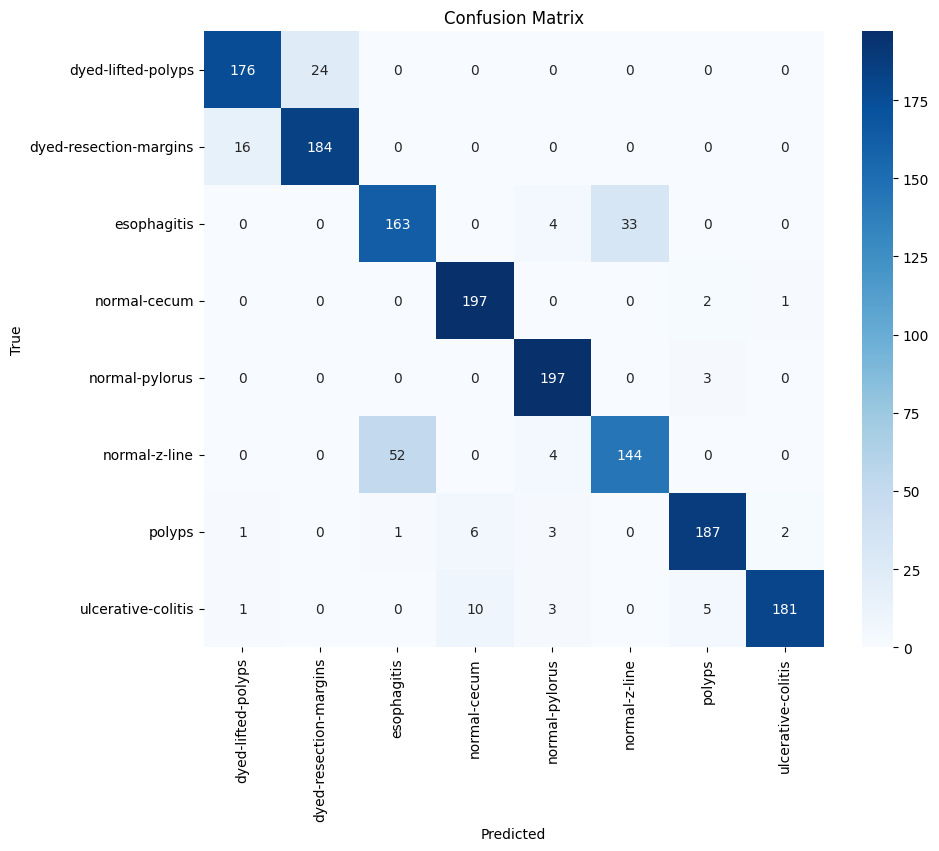

In [22]:
true_labels = []
predicted_labels = []

class_mapping = {
    0: 'dyed-lifted-polyps',
    1: 'dyed-resection-margins',
    2: 'esophagitis',
    3: 'normal-cecum',
    4: 'normal-pylorus',
    5: 'normal-z-line',
    6: 'polyps',
    7: 'ulcerative-colitis',
}

# Iterate through the dataset to get true and predicted labels
for batch in test_loader:  # Replace test_loader with your actual test data loader
    inputs, labels = batch
    with torch.no_grad():
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)

    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

# Create the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predict a single image from test dataset

In [18]:
from PIL import Image

image_path = 'dataset/test/dyed-lifted-polyps/02c10865-9d23-4f6b-aa5d-f73b63b6d67f.jpg'
image = Image.open(image_path)
image = test_transform(image)
image = image.unsqueeze(0)

# Make a forward pass to obtain predictions
with torch.no_grad():
    output = loaded_model(image)

# Interpret the predictions
probs = torch.softmax(output, dim=1)

top5_probs, top5_indices = torch.topk(probs, k=5)


# Print the top 5 predicted class labels, their probabilities, and indices
for i, (label_idx, prob) in enumerate(zip(top5_indices[0], top5_probs[0]), 1):
    class_label = class_mapping[label_idx.item()]
    print(f"Rank {i}: Class: {class_label}, Probability: {prob.item():.4f}")

Rank 1: Class: dyed-lifted-polyps, Probability: 0.8840
Rank 2: Class: dyed-resection-margins, Probability: 0.1099
Rank 3: Class: esophagitis, Probability: 0.0022
Rank 4: Class: normal-z-line, Probability: 0.0019
Rank 5: Class: ulcerative-colitis, Probability: 0.0009


# Kvasir GI Image Classification with EfficientViT and PyTorch Lightning

 This project focuses on building an efficient deep learning model for the classification of GI images into different categories, enabling automated and accurate disease identification.

 ## Dataset
 The Kvasir dataset comprises annotated medical images of the gastrointestinal (GI) tract, with each class showing various Glandmarks, pathological findings, and endoscopic procedures. The dataset includes hundreds of images for each class, making it suitable for tasks such as machine learning, deep learning, and transfer learning. It covers anatomical landmarks like the Z-line, pylorus, and cecum, as well as pathological findings such as esophagitis, polyps, and ulcerative colitis. Additionally, there are images related to lesion removal procedures, like "dyed and lifted polyp" and "dyed resection margins." The images vary in resolution, ranging from 720x576 to 1920x1072 pixels, and are organized into folders corresponding to their content. Some images contain a green picture-in-picture overlay showing the endoscope's position and configuration, which can aid in interpretation but should be handled carefully when detecting endoscopic findings.

## Data Transformation and Augmentation
### Data Augmentation for Training
- To enhance model robustness, a series of data augmentations are applied during training:
- Random Horizontal Flip: Images are randomly flipped horizontally.
- Random Vertical Flip: Images are randomly flipped vertically.
- Random Rotation (up to 15 degrees): Images undergo random rotation.
- Resize to a specified image size (e.g., 224x224 pixels).
- Conversion to PyTorch tensor.
- Normalization using ImageNet statistics.

### Data Transformation for Validation and Testing
- For validation and testing, a simpler transformation pipeline is used:
- Resize to a specified image size.
- Conversion to PyTorch tensor.
- Normalization using ImageNet statistics.

### Dataset Preparation
The training dataset includes a split of 90% training and 10% validation data. The dataset is organized into training, validation, and testing sets. Test transform use on test and validation dataset.

## Model Training using PyTorch Lightning
### Model Initialization
- The selected model architecture is 'efficientvit_m3,' loaded with pre-trained weights.
- A custom PyTorch Lightning module is defined for training and evaluation.

### Training Configuration
- Training is conducted for a specified number of epochs (e.g., 20) using a 16-bit precision.
- Model checkpoints are saved during training.

###Training and Validation Metrics
- During training, various metrics are logged:
  - Accuracy
  - Top-3 Accuracy
  - Top-5 Accuracy
  - F1 Score
  - Loss
- Metrics are tracked for both the training and validation datasets.

## Result:
- Train Accuracy: 0.9688
- Train Top-3 Accuracy: 1.0000
- Train Top-5 Accuracy: 1.0000
- Train Loss: 0.1443
- Train F1 Score: 0.9773
- Validation Accuracy: 0.9016
- Validation Top-3 Accuracy: 1.0000
- Validation Top-5 Accuracy: 1.0000
- Validation Loss: 0.2466
- Validation F1 Score: 0.8930
- Test Accuracy: 0.9049
- Test Top-3 Accuracy: 0.9994
- Test Top-5 Accuracy: 1.0000
- Test Loss: 0.2621
- Test F1 Score: 0.5420
